In [1]:
import numpy as np
import pandas as pd

def estimate_parameters_from_real_data(df, initial_u=1.12, initial_d=1/1.12, temp=5, cooling_rate=0.99, max_iterations=10000, random_seed=None):
    if random_seed is None:
        random_seed = 299 # np.random.randint(1, 401)
        print(random_seed)
    np.random.seed(random_seed)

    # Extract closing prices from the DataFrame
    X = df['Close'].values

    # Normalize the data between 0 and 1
    X_min = np.min(X)
    X_max = np.max(X)
    X = (X - X_min) / (X_max - X_min)

    N = len(X) - 1  # Number of increments
    T = N  # Total time
    dt = T / N  # Time step size

    # Compute the increments
    Delta_X = np.diff(X)

    # Define the objective function
    def objective_function(u, d):
        return np.sum((Delta_X - (0.5 * np.log(u * d) * X[:-1] * dt +
                                  (1 / (2 * dt)) * np.log(u / d) * X[:-1] * np.random.randn(N) / np.sqrt(N)))**2)

    # Simulated Annealing algorithm
    def simulated_annealing(objective_function, initial_u, initial_d, temp, cooling_rate, max_iterations):
        current_u = initial_u
        current_d = initial_d
        current_objective = objective_function(current_u, current_d)
        best_u = current_u
        best_d = current_d
        best_objective = current_objective

        for i in range(max_iterations):
            # Generate new candidate solutions by adding small perturbations
            candidate_u = current_u + np.random.normal(0, 0.1)
            candidate_d = current_d + np.random.normal(0, 0.1)

            # Ensure candidate_u and candidate_d remain positive and candidate_u > candidate_d
            candidate_u = max(candidate_u, 1e-6)
            candidate_d = max(candidate_d, 1e-6)
            if candidate_u <= candidate_d:
                candidate_u, candidate_d = candidate_d, candidate_u

            candidate_objective = objective_function(candidate_u, candidate_d)

            # Calculate acceptance probability
            acceptance_prob = np.exp((current_objective - candidate_objective) / temp)

            # Accept the new solution with a certain probability
            if candidate_objective < current_objective or np.random.rand() < acceptance_prob:
                current_u = candidate_u
                current_d = candidate_d
                current_objective = candidate_objective

                # Update the best solution found
                if candidate_objective < best_objective:
                    best_u = candidate_u
                    best_d = candidate_d
                    best_objective = candidate_objective

            # Cool down the temperature
            temp *= cooling_rate

        return best_u, best_d, best_objective

    # Run the simulated annealing algorithm
    best_u, best_d, best_objective = simulated_annealing(objective_function, initial_u, initial_d, temp, cooling_rate, max_iterations)

    return best_u, best_d, best_objective


In [2]:
def Mu(x, u, d):
    return -0.5 * np.log(u * d) * x

def su(x, u, d, Dt):
    return (0.5 / Dt) * np.log(u / d) * x

299


C:\Users\User\AppData\Local\Temp\ipykernel_6944\1048588204.py:53: RuntimeWarning: overflow encountered in exp
  acceptance_prob = np.exp((current_objective - candidate_objective) / temp)


Estimated u: 1.2171
Estimated d: 0.8171
Best objective function value: 2.0613
0.005141983312904245 0.9797654183980502
Final Error: 0.005141983312904245
Final R-squared: 0.9797654183980502


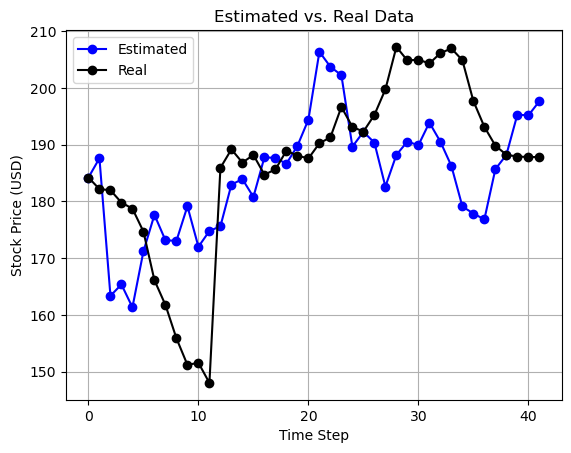

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.special import expit  # Sigmoid function for numerical stability

# Read data from the Excel file
A = pd.read_excel('data4.xlsx', header=None).values.flatten()

# Ensure all values in A are numeric, removing non-numeric entries
A = pd.to_numeric(A, errors='coerce')
A = A[~np.isnan(A)]  # Remove NaNs after conversion

# Create the list of dates
dates = [
    '4/30/2024', '4/29/2024', '4/28/2024', '4/27/2024', '4/26/2024',
    '4/25/2024', '4/24/2024', '4/23/2024', '4/22/2024', '4/21/2024',
    '4/20/2024', '4/19/2024', '5/1/2024', '5/2/2024', '5/3/2024',
    '5/4/2024', '5/5/2024', '5/6/2024', '5/7/2024', '5/8/2024',
    '5/9/2024', '5/10/2024', '5/11/2024', '5/12/2024', '5/13/2024',
    '5/14/2024', '5/15/2024', '5/16/2024', '5/17/2024', '5/18/2024',
    '5/19/2024', '5/20/2024', '5/21/2024', '5/22/2024', '5/23/2024',
    '5/24/2024', '5/25/2024', '5/26/2024', '5/27/2024', '5/28/2024',
    '5/29/2024', '5/30/2024'
]

# Check the lengths of both lists
if len(dates) != len(A):
    print(f"Length mismatch: Dates ({len(dates)}) and Close prices ({len(A)})")
    # Optionally, handle the mismatch here, such as trimming or extending the arrays
    min_length = min(len(dates), len(A))
    dates = dates[:min_length]
    A = A[:min_length]

# Create the DataFrame with the dates and close values
data = pd.DataFrame({
    'Date': pd.to_datetime(dates, format='%m/%d/%Y'),
    'Close': A
})

# Sort the data by date
data = data.sort_values('Date')

# Initialize variables
iter_count = 0
while True:
    best_u, best_d, best_objective = estimate_parameters_from_real_data(data)

    print(f'Estimated u: {best_u:.4f}')
    print(f'Estimated d: {best_d:.4f}')
    # Ensure best_objective is properly scaled with numeric A values
    best_objective_value = np.sqrt((best_objective * (np.max(A) - np.min(A)) + np.min(A)) / len(A))
    print(f'Best objective function value: {best_objective_value:.4f}')

    Y = data['Close'].values
    X = np.zeros(len(Y))
    X[0] = Y[0]
    u = best_u
    d = best_d
    dt = 1
    N = len(Y)

    path = np.zeros((1000, N))
    iter_count += 1
    V = np.zeros(N)
    for j in range(N - 1):
        X[j + 1] = X[j] + Mu(X[j], u, d) * dt + su(X[j], u, d, dt) * np.random.randn() / np.sqrt(N)
        V[j + 1] = (X[j + 1] - Y[j]) / N

    err = np.abs(np.mean((Y - X) / Y))
    Regss = np.sum(V ** 2)
    Ybar = np.mean(Y)
    Tss = np.mean((Y - Ybar) ** 2)
    Rsq = 1 - Regss / Tss
    print(err,Rsq)
    if (Rsq > 0.96) and (err < 0.045): # and (X[14] >= 160):  # X[15] in MATLAB is X[14] in Python
        break

print(f'Final Error: {err}')
print(f'Final R-squared: {Rsq}')

# Plotting the results
plt.plot(range(len(X)), X, 'o-', color='blue',  label='Estimated')
plt.plot(range(len(Y)), Y, 'o-',color='black', label='Real')
plt.grid(True)
plt.title('Estimated vs. Real Data')
plt.xlabel('Time Step')
plt.ylabel('Stock Price (USD)')
plt.legend()
plt.show()

YSAA=X

In [17]:
import numpy as np
import pandas as pd

def estimate_parameters_from_real_data(df, initial_u=1.12, initial_d=1/1.12, max_iterations=10000, random_seed=None, num_wolves=30):
    if random_seed is None:
        random_seed = 179 # np.random.randint(1, 401)
        print(f"Random seed: {random_seed}")
    np.random.seed(random_seed)

    # Extract closing prices from the DataFrame
    X = df['Close'].values

    # Normalize the data between 0 and 1
    X_min = np.min(X)
    X_max = np.max(X)
    X = (X - X_min) / (X_max - X_min)

    N = len(X) - 1  # Number of increments
    T = N  # Total time
    dt = T / N  # Time step size

    # Compute the increments
    Delta_X = np.diff(X)

    # Define the objective function
    def objective_function(u, d):
        return np.sum((Delta_X - (0.5 * np.log(u * d) * X[:-1] * dt +
                                  (1 / (2 * dt)) * np.log(u / d) * X[:-1] * np.random.randn(N) / np.sqrt(N)))**2)

    # Gray Wolf Optimization algorithm
    def gray_wolf_optimization(objective_function, num_wolves, max_iterations):
        # Initialize positions of alpha, beta, and delta wolves
        alpha_pos = np.random.uniform(0.5, 1.5, 2)  # Best position found by alpha
        beta_pos = np.random.uniform(0.5, 1.5, 2)   # Second best position found by beta
        delta_pos = np.random.uniform(0.5, 1.5, 2)  # Third best position found by delta

        # Initialize positions of other wolves
        wolves_pos = np.random.uniform(0.5, 1.5, (num_wolves, 2))

        # Initialize best objectives
        alpha_score = float('inf')  # Best score found by alpha
        beta_score = float('inf')   # Second best score found by beta
        delta_score = float('inf')  # Third best score found by delta

        for iter in range(max_iterations):
            for i in range(num_wolves):
                u, d = wolves_pos[i]
                # Ensure candidate_u and candidate_d remain positive and candidate_u > candidate_d
                u = max(u, 1e-6)
                d = max(d, 1e-6)
                if u <= d:
                    u, d = d, u
                wolves_pos[i] = [u, d]

                # Calculate the objective for the current wolf
                score = objective_function(u, d)

                # Update alpha, beta, and delta wolves
                if score < alpha_score:
                    alpha_score = score
                    alpha_pos = wolves_pos[i].copy()
                elif score < beta_score:
                    beta_score = score
                    beta_pos = wolves_pos[i].copy()
                elif score < delta_score:
                    delta_score = score
                    delta_pos = wolves_pos[i].copy()

            # Update positions of all wolves
            a = 2 - iter * (2 / max_iterations)  # a decreases linearly from 2 to 0

            for i in range(num_wolves):
                r1 = np.random.rand(2)
                r2 = np.random.rand(2)

                A1 = 2 * a * r1 - a
                C1 = 2 * r2

                D_alpha = np.abs(C1 * alpha_pos - wolves_pos[i])
                X1 = alpha_pos - A1 * D_alpha

                r1 = np.random.rand(2)
                r2 = np.random.rand(2)

                A2 = 2 * a * r1 - a
                C2 = 2 * r2

                D_beta = np.abs(C2 * beta_pos - wolves_pos[i])
                X2 = beta_pos - A2 * D_beta

                r1 = np.random.rand(2)
                r2 = np.random.rand(2)

                A3 = 2 * a * r1 - a
                C3 = 2 * r2

                D_delta = np.abs(C3 * delta_pos - wolves_pos[i])
                X3 = delta_pos - A3 * D_delta

                # Update wolf position
                wolves_pos[i] = (X1 + X2 + X3) / 3

        # Return the best position and objective found
        return alpha_pos[0], alpha_pos[1], alpha_score

    # Run the Gray Wolf Optimization algorithm
    best_u, best_d, best_objective = gray_wolf_optimization(objective_function, num_wolves, max_iterations)

    return best_u, best_d, best_objective


Random seed: 179
Estimated u: 1.2557
Estimated d: 0.7929
Best objective function value: 2.0541
0.0014087882410439045 0.980321707402716
Final Error: 0.0014087882410439045
Final R-squared: 0.980321707402716


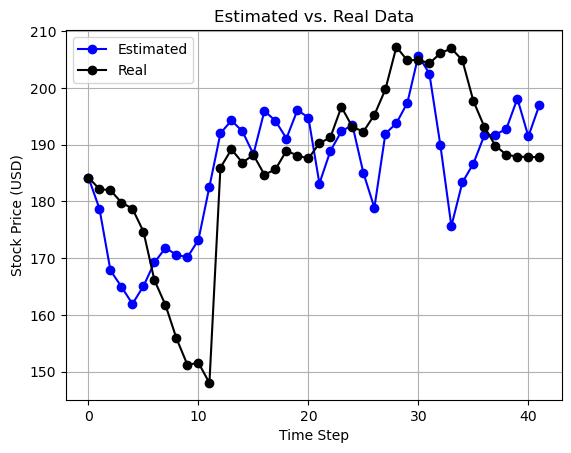

In [18]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.special import expit  # Sigmoid function for numerical stability

# Read data from the Excel file
A = pd.read_excel('data4.xlsx', header=None).values.flatten()

# Ensure all values in A are numeric, removing non-numeric entries
A = pd.to_numeric(A, errors='coerce')
A = A[~np.isnan(A)]  # Remove NaNs after conversion

# Create the list of dates
dates = [
    '4/30/2024', '4/29/2024', '4/28/2024', '4/27/2024', '4/26/2024',
    '4/25/2024', '4/24/2024', '4/23/2024', '4/22/2024', '4/21/2024',
    '4/20/2024', '4/19/2024', '5/1/2024', '5/2/2024', '5/3/2024',
    '5/4/2024', '5/5/2024', '5/6/2024', '5/7/2024', '5/8/2024',
    '5/9/2024', '5/10/2024', '5/11/2024', '5/12/2024', '5/13/2024',
    '5/14/2024', '5/15/2024', '5/16/2024', '5/17/2024', '5/18/2024',
    '5/19/2024', '5/20/2024', '5/21/2024', '5/22/2024', '5/23/2024',
    '5/24/2024', '5/25/2024', '5/26/2024', '5/27/2024', '5/28/2024',
    '5/29/2024', '5/30/2024'
]

# Check the lengths of both lists
if len(dates) != len(A):
    print(f"Length mismatch: Dates ({len(dates)}) and Close prices ({len(A)})")
    # Optionally, handle the mismatch here, such as trimming or extending the arrays
    min_length = min(len(dates), len(A))
    dates = dates[:min_length]
    A = A[:min_length]

# Create the DataFrame with the dates and close values
data = pd.DataFrame({
    'Date': pd.to_datetime(dates, format='%m/%d/%Y'),
    'Close': A
})

# Sort the data by date
data = data.sort_values('Date')

# Initialize variables
iter_count = 0
while True:
    best_u, best_d, best_objective = estimate_parameters_from_real_data(data)

    print(f'Estimated u: {best_u:.4f}')
    print(f'Estimated d: {best_d:.4f}')
    # Ensure best_objective is properly scaled with numeric A values
    best_objective_value = np.sqrt((best_objective * (np.max(A) - np.min(A)) + np.min(A)) / len(A))
    print(f'Best objective function value: {best_objective_value:.4f}')

    Y = data['Close'].values
    X = np.zeros(len(Y))
    X[0] = Y[0]
    u = best_u
    d = best_d
    dt = 1
    N = len(Y)

    path = np.zeros((1000, N))
    iter_count += 1
    V = np.zeros(N)
    for j in range(N - 1):
        X[j + 1] = X[j] + Mu(X[j], u, d) * dt + su(X[j], u, d, dt) * np.random.randn() / np.sqrt(N)
        V[j + 1] = (X[j + 1] - Y[j]) / N

    err = np.abs(np.mean((Y - X) / Y))
    Regss = np.sum(V ** 2)
    Ybar = np.mean(Y)
    Tss = np.mean((Y - Ybar) ** 2)
    Rsq = 1 - Regss / Tss
    print(err,Rsq)
    if (Rsq > 0.96) and (err < 0.01): # and (X[14] >= 160):  # X[15] in MATLAB is X[14] in Python
        break

print(f'Final Error: {err}')
print(f'Final R-squared: {Rsq}')

# Plotting the results
plt.plot(range(len(X)), X, 'o-', color='blue',  label='Estimated')
plt.plot(range(len(Y)), Y, 'o-',color='black', label='Real')
plt.grid(True)
plt.title('Estimated vs. Real Data')
plt.xlabel('Time Step')
plt.ylabel('Stock Price (USD)')
plt.legend()
plt.show()

YGWO=X

In [6]:
import numpy as np
import pandas as pd

def estimate_parameters_from_real_data(df, initial_u=1.12, initial_d=1/1.12, max_iterations=10000, random_seed=None, swarm_size=30, inertia=0.5, cognitive=1.5, social=1.5):
    if random_seed is None:
        random_seed = 57 # np.random.randint(1, 401)
        print(f"Random seed: {random_seed}")
    np.random.seed(random_seed)

    # Extract closing prices from the DataFrame
    X = df['Close'].values

    # Normalize the data between 0 and 1
    X_min = np.min(X)
    X_max = np.max(X)
    X = (X - X_min) / (X_max - X_min)

    N = len(X) - 1  # Number of increments
    T = N  # Total time
    dt = T / N  # Time step size

    # Compute the increments
    Delta_X = np.diff(X)

    # Define the objective function
    def objective_function(u, d):
        return np.sum((Delta_X - (0.5 * np.log(u * d) * X[:-1] * dt +
                                  (1 / (2 * dt)) * np.log(u / d) * X[:-1] * np.random.randn(N) / np.sqrt(N)))**2)

    # Particle Swarm Optimization algorithm
    def particle_swarm_optimization(objective_function, swarm_size, max_iterations, inertia, cognitive, social):
        # Initialize particle positions and velocities
        particle_positions = np.random.uniform(0.5, 1.5, (swarm_size, 2))
        particle_velocities = np.zeros((swarm_size, 2))

        # Initialize personal and global best positions and scores
        personal_best_positions = particle_positions.copy()
        personal_best_scores = np.array([objective_function(u, d) for u, d in particle_positions])
        global_best_position = personal_best_positions[np.argmin(personal_best_scores)]
        global_best_score = np.min(personal_best_scores)

        for iter in range(max_iterations):
            for i in range(swarm_size):
                # Update velocity
                r1, r2 = np.random.rand(2)
                particle_velocities[i] = (inertia * particle_velocities[i] +
                                          cognitive * r1 * (personal_best_positions[i] - particle_positions[i]) +
                                          social * r2 * (global_best_position - particle_positions[i]))

                # Update position
                particle_positions[i] += particle_velocities[i]

                # Ensure candidate_u and candidate_d remain positive and candidate_u > candidate_d
                u, d = particle_positions[i]
                u = max(u, 1e-6)
                d = max(d, 1e-6)
                if u <= d:
                    u, d = d, u
                particle_positions[i] = [u, d]

                # Evaluate new position
                score = objective_function(u, d)

                # Update personal best
                if score < personal_best_scores[i]:
                    personal_best_positions[i] = particle_positions[i]
                    personal_best_scores[i] = score

                    # Update global best
                    if score < global_best_score:
                        global_best_position = particle_positions[i]
                        global_best_score = score

        return global_best_position[0], global_best_position[1], global_best_score

    # Run the Particle Swarm Optimization algorithm
    best_u, best_d, best_objective = particle_swarm_optimization(objective_function, swarm_size, max_iterations, inertia, cognitive, social)

    return best_u, best_d, best_objective


Random seed: 57
Estimated u: 1.0847
Estimated d: 0.9161
Best objective function value: 2.0619
0.0034242823870659837 0.9820659082641023
Final Error: 0.0034242823870659837
Final R-squared: 0.9820659082641023


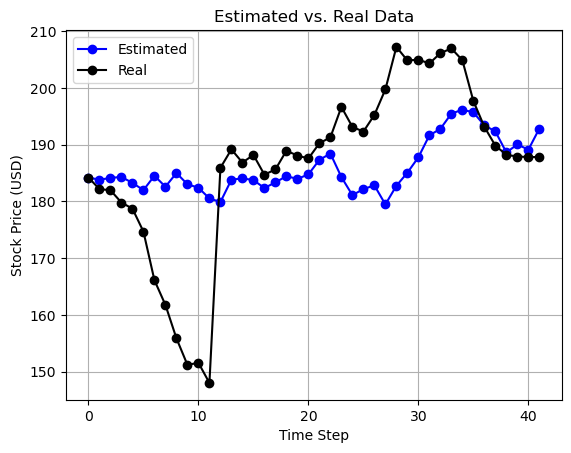

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.special import expit  # Sigmoid function for numerical stability

# Read data from the Excel file
A = pd.read_excel('data4.xlsx', header=None).values.flatten()

# Ensure all values in A are numeric, removing non-numeric entries
A = pd.to_numeric(A, errors='coerce')
A = A[~np.isnan(A)]  # Remove NaNs after conversion

# Create the list of dates
dates = [
    '4/30/2024', '4/29/2024', '4/28/2024', '4/27/2024', '4/26/2024',
    '4/25/2024', '4/24/2024', '4/23/2024', '4/22/2024', '4/21/2024',
    '4/20/2024', '4/19/2024', '5/1/2024', '5/2/2024', '5/3/2024',
    '5/4/2024', '5/5/2024', '5/6/2024', '5/7/2024', '5/8/2024',
    '5/9/2024', '5/10/2024', '5/11/2024', '5/12/2024', '5/13/2024',
    '5/14/2024', '5/15/2024', '5/16/2024', '5/17/2024', '5/18/2024',
    '5/19/2024', '5/20/2024', '5/21/2024', '5/22/2024', '5/23/2024',
    '5/24/2024', '5/25/2024', '5/26/2024', '5/27/2024', '5/28/2024',
    '5/29/2024', '5/30/2024'
]

# Check the lengths of both lists
if len(dates) != len(A):
    print(f"Length mismatch: Dates ({len(dates)}) and Close prices ({len(A)})")
    # Optionally, handle the mismatch here, such as trimming or extending the arrays
    min_length = min(len(dates), len(A))
    dates = dates[:min_length]
    A = A[:min_length]

# Create the DataFrame with the dates and close values
data = pd.DataFrame({
    'Date': pd.to_datetime(dates, format='%m/%d/%Y'),
    'Close': A
})

# Sort the data by date
data = data.sort_values('Date')

# Initialize variables
iter_count = 0
while True:
    best_u, best_d, best_objective = estimate_parameters_from_real_data(data)

    print(f'Estimated u: {best_u:.4f}')
    print(f'Estimated d: {best_d:.4f}')
    # Ensure best_objective is properly scaled with numeric A values
    best_objective_value = np.sqrt((best_objective * (np.max(A) - np.min(A)) + np.min(A)) / len(A))
    print(f'Best objective function value: {best_objective_value:.4f}')

    Y = data['Close'].values
    X = np.zeros(len(Y))
    X[0] = Y[0]
    u = best_u
    d = best_d
    dt = 1
    N = len(Y)

    path = np.zeros((1000, N))
    iter_count += 1
    V = np.zeros(N)
    for j in range(N - 1):
        X[j + 1] = X[j] + Mu(X[j], u, d) * dt + su(X[j], u, d, dt) * np.random.randn() / np.sqrt(N)
        V[j + 1] = (X[j + 1] - Y[j]) / N

    err = np.abs(np.mean((Y - X) / Y))
    Regss = np.sum(V ** 2)
    Ybar = np.mean(Y)
    Tss = np.mean((Y - Ybar) ** 2)
    Rsq = 1 - Regss / Tss
    print(err,Rsq)
    if (Rsq > 0.96) and (err < 0.045): # and (X[14] >= 160):  # X[15] in MATLAB is X[14] in Python
        break

print(f'Final Error: {err}')
print(f'Final R-squared: {Rsq}')

# Plotting the results
plt.plot(range(len(X)), X, 'o-', color='blue',  label='Estimated')
plt.plot(range(len(Y)), Y, 'o-',color='black', label='Real')
plt.grid(True)
plt.title('Estimated vs. Real Data')
plt.xlabel('Time Step')
plt.ylabel('Stock Price (USD)')
plt.legend()
plt.show()

YPSO=X

In [8]:
import numpy as np
import pandas as pd

def estimate_parameters_from_real_data(df, initial_u=1.12, initial_d=1/1.12, max_iterations=10000, random_seed=None, population_size=30, mutation_factor=0.8, crossover_probability=0.7):
    if random_seed is None:
        random_seed = 234 #  np.random.randint(1, 401) 
        print(f"Random seed: {random_seed}")
    np.random.seed(random_seed)

    # Extract closing prices from the DataFrame
    X = df['Close'].values

    # Normalize the data between 0 and 1
    X_min = np.min(X)
    X_max = np.max(X)
    X = (X - X_min) / (X_max - X_min)

    N = len(X) - 1  # Number of increments
    T = N  # Total time
    dt = T / N  # Time step size

    # Compute the increments
    Delta_X = np.diff(X)

    # Define the objective function
    def objective_function(u, d):
        return np.sum((Delta_X - (0.5 * np.log(u * d) * X[:-1] * dt +
                                  (1 / (2 * dt)) * np.log(u / d) * X[:-1] * np.random.randn(N) / np.sqrt(N)))**2)

    # Differential Evolution algorithm
    def differential_evolution(objective_function, population_size, max_iterations, mutation_factor, crossover_probability):
        # Initialize population
        population = np.random.uniform(0.5, 1.5, (population_size, 2))

        # Evaluate the objective function for the initial population
        fitness = np.array([objective_function(u, d) for u, d in population])

        for iter in range(max_iterations):
            for i in range(population_size):
                # Mutation: randomly select three different individuals
                indices = [idx for idx in range(population_size) if idx != i]
                a, b, c = population[np.random.choice(indices, 3, replace=False)]

                # Mutant vector
                mutant = a + mutation_factor * (b - c)

                # Crossover: create trial vector
                trial = np.where(np.random.rand(2) < crossover_probability, mutant, population[i])

                # Ensure trial vector constraints: positive values and u > d
                u, d = trial
                u = max(u, 1e-6)
                d = max(d, 1e-6)
                if u <= d:
                    u, d = d, u
                trial = [u, d]

                # Evaluate trial vector
                trial_fitness = objective_function(trial[0], trial[1])

                # Selection: replace if trial is better
                if trial_fitness < fitness[i]:
                    population[i] = trial
                    fitness[i] = trial_fitness

        # Find the best solution in the final population
        best_index = np.argmin(fitness)
        best_u, best_d = population[best_index]
        best_objective = fitness[best_index]

        return best_u, best_d, best_objective

    # Run the Differential Evolution algorithm
    best_u, best_d, best_objective = differential_evolution(objective_function, population_size, max_iterations, mutation_factor, crossover_probability)

    return best_u, best_d, best_objective


Random seed: 234
Estimated u: 1.4110
Estimated d: 0.7014
Best objective function value: 2.0559
0.03291319963876006 0.9612725581651518
Final Error: 0.03291319963876006
Final R-squared: 0.9612725581651518


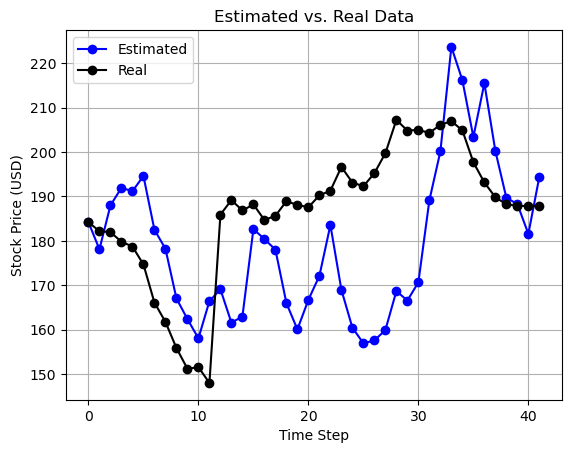

In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.special import expit  # Sigmoid function for numerical stability

# Read data from the Excel file
A = pd.read_excel('data4.xlsx', header=None).values.flatten()

# Ensure all values in A are numeric, removing non-numeric entries
A = pd.to_numeric(A, errors='coerce')
A = A[~np.isnan(A)]  # Remove NaNs after conversion

# Create the list of dates
dates = [
    '4/30/2024', '4/29/2024', '4/28/2024', '4/27/2024', '4/26/2024',
    '4/25/2024', '4/24/2024', '4/23/2024', '4/22/2024', '4/21/2024',
    '4/20/2024', '4/19/2024', '5/1/2024', '5/2/2024', '5/3/2024',
    '5/4/2024', '5/5/2024', '5/6/2024', '5/7/2024', '5/8/2024',
    '5/9/2024', '5/10/2024', '5/11/2024', '5/12/2024', '5/13/2024',
    '5/14/2024', '5/15/2024', '5/16/2024', '5/17/2024', '5/18/2024',
    '5/19/2024', '5/20/2024', '5/21/2024', '5/22/2024', '5/23/2024',
    '5/24/2024', '5/25/2024', '5/26/2024', '5/27/2024', '5/28/2024',
    '5/29/2024', '5/30/2024'
]

# Check the lengths of both lists
if len(dates) != len(A):
    print(f"Length mismatch: Dates ({len(dates)}) and Close prices ({len(A)})")
    # Optionally, handle the mismatch here, such as trimming or extending the arrays
    min_length = min(len(dates), len(A))
    dates = dates[:min_length]
    A = A[:min_length]

# Create the DataFrame with the dates and close values
data = pd.DataFrame({
    'Date': pd.to_datetime(dates, format='%m/%d/%Y'),
    'Close': A
})

# Sort the data by date
data = data.sort_values('Date')

# Initialize variables
iter_count = 0
while True:
    best_u, best_d, best_objective = estimate_parameters_from_real_data(data)

    print(f'Estimated u: {best_u:.4f}')
    print(f'Estimated d: {best_d:.4f}')
    # Ensure best_objective is properly scaled with numeric A values
    best_objective_value = np.sqrt((best_objective * (np.max(A) - np.min(A)) + np.min(A)) / len(A))
    print(f'Best objective function value: {best_objective_value:.4f}')

    Y = data['Close'].values
    X = np.zeros(len(Y))
    X[0] = Y[0]
    u = best_u
    d = best_d
    dt = 1
    N = len(Y)

    path = np.zeros((1000, N))
    iter_count += 1
    V = np.zeros(N)
    for j in range(N - 1):
        X[j + 1] = X[j] + Mu(X[j], u, d) * dt + su(X[j], u, d, dt) * np.random.randn() / np.sqrt(N)
        V[j + 1] = (X[j + 1] - Y[j]) / N

    err = np.abs(np.mean((Y - X) / Y))
    Regss = np.sum(V ** 2)
    Ybar = np.mean(Y)
    Tss = np.mean((Y - Ybar) ** 2)
    Rsq = 1 - Regss / Tss
    print(err,Rsq)
    if (Rsq > 0.96) and (err < 0.045): # and (X[14] >= 160):  # X[15] in MATLAB is X[14] in Python
        break

print(f'Final Error: {err}')
print(f'Final R-squared: {Rsq}')

# Plotting the results
plt.plot(range(len(X)), X, 'o-', color='blue',  label='Estimated')
plt.plot(range(len(Y)), Y, 'o-',color='black', label='Real')
plt.grid(True)
plt.title('Estimated vs. Real Data')
plt.xlabel('Time Step')
plt.ylabel('Stock Price (USD)')
plt.legend()
plt.show()

YDE=X

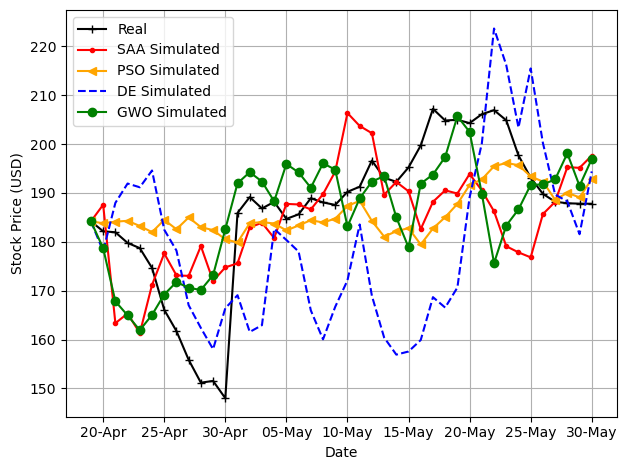

In [10]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime, timedelta

# Assuming Y, YSAA, YPSO, YDE, YGWO are your data series
# Creating a date range from 19th April to match the length of Y
start_date = datetime(2024, 4, 19)
dates = [start_date + timedelta(days=i) for i in range(len(Y))]

 

# Plotting the data
plt.plot(dates, Y, '+-', color='black', label='Real')
plt.plot(dates, YSAA, '.-', color='red', label='SAA Simulated')
plt.plot(dates, YPSO, '<-', color='orange', label='PSO Simulated')
plt.plot(dates, YDE, '--', color='blue', label='DE Simulated')
plt.plot(dates, YGWO, 'o-', color='green', label='GWO Simulated')

# Formatting the x-axis to display dates properly
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%d-%b'))
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=5))  # Adjust interval to skip some dates

plt.xlabel('Date')
plt.ylabel('Stock Price (USD)')
#plt.title('Stock Price Simulation Comparison')
plt.grid(True)
plt.legend()
plt.xticks(rotation=0)
plt.tight_layout()
plt.savefig('patjon.png')  # Save as PNG
plt.show()


In [11]:
def european_option_self_financing(S_0, K, r, u, d, n, optionType):
    dt = 1.0 / (n*365)
    V = np.zeros((n+1, n+1))
    S = np.zeros((n+1, n+1))
    p = (np.exp(r * dt) - d) / (u - d)

    # Initialize matrices
    V = np.zeros((n + 1, n + 1))
    S = np.zeros((n + 1, n + 1))
    Delta = np.zeros((n + 1, n + 1))
    Psi = np.zeros((n + 1, n + 1))

    for i in range(n + 1):
        for j in range(i + 1):
            S[i, j] = S_0 * (u ** j) * (d ** (i - j))
            if optionType == "call":
                V[i, j] = max(0, S[i, j] - K)
            else:
                V[i, j] = max(0, K - S[i, j])

    for i in range(n - 1, -1, -1):
        for j in range(i + 1):
            continuationValue = np.exp(-r * dt) * (p * V[i + 1, j + 1] + (1 - p) * V[i + 1, j])
            if optionType == "call":
                V[i, j] = max(S[i, j] - K, continuationValue)
            else:
                V[i, j] = max(K - S[i, j], continuationValue)

    return V[0, 0]

In [12]:
def american_option_self_financing(S_0, K, r, u, d, n, optionType, earlyExerciseThreshold=1.2, transactionCost=0.21):
    """
    Calculates the price of an American option using a binomial tree model with early exercise check.

    Args:
        S_0: Initial stock price.
        K: Strike price.
        r: Interest rate.
        u: Up factor.
        d: Down factor.
        n: Number of time steps.
        optionType: "call" or "put".
        earlyExerciseThreshold: Threshold for prioritizing early exercise (default 0.95).
        transactionCost: Transaction cost for early exercise (default 0).

    Returns:
        The price of the American option.
    """

    dt = 1 / (n*365)
    p = (np.exp(r * dt) - d) / (u - d)

    # Initialize matrices
    V = np.zeros((n + 1, n + 1))
    S = np.zeros((n + 1, n + 1))
    Delta = np.zeros((n + 1, n + 1))
    Psi = np.zeros((n + 1, n + 1))

    # Populate the stock price matrix S
    for i in range(n + 1):
        for j in range(i + 1):
            S[i, j] = S_0 * (u ** j) * (d ** (i - j))

    # Calculate the option payoff at maturity
    for j in range(n + 1):
        if optionType == "call":
            V[n, j] = max(0, S[n, j] - K)
        else:
            V[n, j] = max(0, K - S[n, j])

    # Perform backward induction to calculate the option price and replicating portfolio
    for i in range(n - 1, -1, -1):
        for j in range(i + 1):
            continuationValue = np.exp(-r * dt) * (p * V[i + 1, j + 1] + (1 - p) * V[i + 1, j])
            if optionType == "call":
                exerciseValue = S[i, j] - K - transactionCost
                earlyExerciseValue = max(exerciseValue, 0)
                V[i, j] = max(earlyExerciseValue, continuationValue)
            else:
                exerciseValue = K - S[i, j] - transactionCost
                earlyExerciseValue = max(exerciseValue, 0)
                V[i, j] = max(earlyExerciseValue, continuationValue)

            Delta[i, j] = (V[i + 1, j + 1] - V[i + 1, j]) / (S[i + 1, j + 1] - S[i + 1, j])
            Psi[i, j] = np.exp(-r * dt) * (V[i + 1, j] - Delta[i, j] * S[i + 1, j])

            V[i, j] = Delta[i, j] * S[i, j] + Psi[i, j]

    return V[0, 0]

# **Calculation of Premiums for SAA**

In [13]:
K = 180
r = 0.05
n=int(len(Y)/2)-1
s0=Y[0]
#SAA

uSAA=1.2171
dSAA=0.8171

optionTypes = ["call", "put"]  # List of option types

for optionType in optionTypes:
   
  # Calculate the option price for an American option
  option_price2 = european_option_self_financing(s0, K, r, uSAA, dSAA, n, optionType)
  print(f"european Option Price ({optionType}): {option_price2}")
  
for optionType in optionTypes:  
  # Calculate the option price for an American option
  option_price = american_option_self_financing(s0, K, r, uSAA, dSAA, n, optionType)
  print(f"American Option Price ({optionType}): {option_price}")

european Option Price (call): 64.43107476646246
european Option Price (put): 60.207823676755304
American Option Price (call): 64.43107476646259
American Option Price (put): 60.20470747589454


# **Premium Calculation for GWO**

In [14]:
K = 180
r = 0.05
n=int(len(Y)/2)-1
s0=Y[0]
 
uGWO=1.2557
dGWO=0.7929

optionTypes = ["call", "put"]  # List of option types

for optionType in optionTypes:
   
  # Calculate the option price for an American option
  option_price2 = european_option_self_financing(s0, K, r, uGWO, dGWO, n, optionType)
  print(f"european Option Price ({optionType}): {option_price2}")
  # Calculate the option price for an American option
  option_price = american_option_self_financing(s0, K, r, uGWO, dGWO, n, optionType)
  print(f"American Option Price ({optionType}): {option_price}")

european Option Price (call): 73.03877663742634
American Option Price (call): 73.03877663742657
european Option Price (put): 68.81575934839559
American Option Price (put): 68.81240934685852


# **Premium Calculation for PSO**

In [15]:
K = 180
r = 0.05
n=int(len(Y)/2)-1
s0=Y[0]
#SAA

 
uPSO=1.0847
dPSO= 0.9161

optionTypes = ["call", "put"]  # List of option types

for optionType in optionTypes:
   
  # Calculate the option price for an American option
  option_price2 = european_option_self_financing(s0, K, r, uPSO, dPSO, n, optionType)
  print(f"european Option Price ({optionType}): {option_price2}")
  # Calculate the option price for an American option
  option_price = american_option_self_financing(s0, K, r, uPSO, dPSO, n, optionType)
  print(f"American Option Price ({optionType}): {option_price}")

european Option Price (call): 29.57795050649171
American Option Price (call): 29.577950506491845
european Option Price (put): 25.35380285718706
American Option Price (put): 25.35158321592381


# **Premium Calculation for DE**

In [16]:
K = 180
r = 0.05
n=int(len(Y)/2)-1
s0=Y[0]


 
uDE=1.4110
dDE= 0.7014

optionTypes = ["call", "put"]  # List of option types

for optionType in optionTypes:
   
  # Calculate the option price for an American option
  option_price2 = european_option_self_financing(s0, K, r, uDE, dDE, n, optionType)
  print(f"european Option Price ({optionType}): {option_price2}")
  # Calculate the option price for an American option
  option_price = american_option_self_financing(s0, K, r, uDE, dDE, n, optionType)
  print(f"American Option Price ({optionType}): {option_price}")

european Option Price (call): 104.68126473391155
American Option Price (call): 104.68126473391187
european Option Price (put): 100.45891129558903
American Option Price (put): 100.45489744334377
